In [1]:
import sys
import os

# Get the absolute path of the scripts directory
root_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Add the scripts directory to Python's module search path
sys.path.append(root_dir)

# data manipulation and plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# from Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.pipeline import make_pipeline

# from feature-engine
from feature_engine.imputation import AddMissingIndicator, CategoricalImputer
from feature_engine.encoding import RareLabelEncoder, OrdinalEncoder, OneHotEncoder
from feature_engine.transformation import YeoJohnsonTransformer, LogTransformer
from feature_engine.selection import DropFeatures
from feature_engine.outliers import OutlierTrimmer
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso
from sklearn.feature_selection import SelectFromModel

# from scripts
from scripts.preprocessors import (
    IdealistaDataLoader,
    RareValueTrimmer,
    FrequentValueAmputer,
    UnaryFeatureDropper,
    RelativeFeatureGenerator,
    ProximityScoreGenerator
)

In [2]:
# to visualise al the columns in the dataframe
pd.pandas.set_option("display.max_columns", None)
# to display all the rows of the dataframe in the notebook
# pd.pandas.set_option("display.max_rows", None)

# to display the plots in a nice way
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

In [3]:
data_loader = IdealistaDataLoader(
    read_path=f"../data/idealista",
    city="lisbon",
    operation="rent",
    date_or_unioned="unioned",
    include_geodata=True,
    index_col="propertyCode",
)

data = data_loader.load_data()

In [4]:
# rowsandcolumnsofthedata
print(data.shape)

# visualisethedataset
data.head()

(3413, 65)


,thumbnail,externalReference,numPhotos,floor,price,propertyType,operation,size,rooms,bathrooms,address,province,municipality,district,country,latitude,longitude,showAddress,url,distance,description,hasVideo,status,newDevelopment,hasLift,priceByArea,detailedType,suggestedTexts,hasPlan,has3DTour,has360,hasStaging,topNewDevelopment,topPlus,neighborhood,newDevelopmentFinished,snapshotDate,formerPrice,priceChange,isPriceLowered,hasParkingSpace,isParkingSpaceIncludedInPrice,parkingSpacePrice,totalPrice,distanceToCityCenter,distanceToNearestMall,nearestMallName,distanceToNearestTrain,nearestTrainName,distanceToNearestFair,nearestFairName,distanceToNearestPark,nearestParkName,distanceToNearestMarket,nearestMarketName,distanceToNearestMetro,nearestMetroName,distanceToNearestViewpoint,nearestViewpointName,distanceToNearestPlayground,nearestPlaygroundName,distanceToNearestBus,nearestBusName,distanceToNearestTram,nearestTramName
propertyCode,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
33829652,https://img4.idealista.pt/blur/WEB_LISTING/0/i...,KWPT-009130,33,1,2475.0,flat,rent,179.0,3,3,São Sebastião da Pedreira,Lisboa,Avenidas Novas,São Sebastião da Pedreira,pt,38.733429,-9.145003,False,https://www.idealista.pt/imovel/33829652/,439.0,Um apartamento nas Avenidas Novas? Conte-me ma...,False,good,False,True,13.826816,{'typology': 'flat'},"{'subtitle': 'Avenidas Novas, Lisboa', 'title'...",True,False,False,False,False,False,NaN,False,2025-01-13,2475.0,0.0,False,False,False,0.0,2475.0,3902.762342,83.378815,Dolce Vita Monumental,1626.342524,Entrecampos,1337.410328,Feira São João de Deus,466.306263,Jardim do Arco do Cego,1012.055636,Mercado Arco do Cego,250.261820,Saldanha,1142.440298,Miradouro do Parque Eduardo VII,641.621174,Parque Infantil do Jardim Gomes Amorim,64.135685,Saldanha,1890.872576,Rua Maria Andrade
33596155,https://img4.idealista.pt/blur/WEB_LISTING/0/i...,KWPT-004534,33,bj,2150.0,flat,rent,170.0,3,3,rua das Picoas,Lisboa,Avenidas Novas,São Sebastião da Pedreira,pt,38.733908,-9.144531,False,https://www.idealista.pt/imovel/33596155/,373.0,Um apartamento para arrendar? Conte-me mais! E...,True,good,False,True,12.647059,{'typology': 'flat'},"{'subtitle': 'Avenidas Novas, Lisboa', 'title'...",True,False,False,False,False,False,NaN,False,2025-01-13,2150.0,0.0,False,False,False,0.0,2150.0,3954.901443,150.274403,Centro Comercial Atrium Saldanha,1576.198925,Entrecampos,1251.392666,Feira São João de Deus,380.225877,Jardim do Arco do Cego,929.438169,Mercado Arco do Cego,198.676223,Saldanha,1217.962245,Miradouro do Parque Eduardo VII,562.731979,Parque Infantil do Jardim Gomes Amorim,52.045424,Saldanha,1909.529635,Rua Maria Andrade
33896876,https://img4.idealista.pt/blur/WEB_LISTING/0/i...,Match_01.216,21,8,1950.0,flat,rent,135.0,2,2,"rua Jorge Castilho, 8",Lisboa,Areeiro,Casal Vistoso,pt,38.740173,-9.128233,True,https://www.idealista.pt/imovel/33896876/,1303.0,Apartamento T2 Com Varanda e Estacionamento Lo...,False,good,False,True,14.444444,{'typology': 'flat'},"{'subtitle': 'Areeiro, Lisboa', 'title': 'Apar...",True,False,False,False,False,False,NaN,False,2025-01-13,1950.0,0.0,False,True,True,0.0,1950.0,4787.948289,342.638864,Olaias Plaza,1031.109077,Roma Areeiro,1133.090394,Feira São João de Deus,448.850431,Jardim sobre a Fonte Monumental - Alameda Dom ...,696.420381,Mercado da Picheleira - Mercado Alfacinha,582.276537,Olaias,1410.666684,Miradouro da Penha de França,557.606783,Parque Infantil da Rua Aquiles Machado,159.398088,Casal Vistoso,2363.949266,Rua do Forno do Tijolo
31196503,https://img4.idealista.pt/blur/WEB_LISTING/0/i...,CF119,9,1,700.0,studio,rent,25.0,0,1,beco dos Paus,Lisboa,Santa Maria Maior,Alfama - Sé,pt,38.712857,-9.125107,False,https://www.idealista.pt/imovel/31196503/,3082.0,"Excelente apartamento T0, disponível com todo ...",False,good,False,False,28.000000,"{'typology': 'flat', 'subTypology': 'studio'}","{'subtitle': 'Santa Maria Maior, Lisboa', 'tit...",False,False,False,False,False,False,NaN,Fal

In [5]:
proximity_score_generator = ProximityScoreGenerator(
    variables=[
        {
            "target": [
                "distanceToNearestMetro",
                "distanceToNearestBus",
                "distanceToNearestTram",
                "distanceToNearestTrain",
            ],
            "name": "proximityToTransportScore",
        },
        {
            "target": [
                "distanceToNearestPark",
                "distanceToNearestViewpoint",
            ],
            "name": "proximityToGreenSpaceScore",
        },
    ]
)
proximity_score_generator.fit(data)
data = proximity_score_generator.transform(data)

In [6]:
relative_feature_generator = RelativeFeatureGenerator(
    variables=[
        {
            "groupby": "district",
            "agg": "mean",
            "target": "priceByArea",
            "name": "relativePriceByArea",
        }
    ]
)
relative_feature_generator.fit(data)
data = relative_feature_generator.transform(data)

In [7]:
data['listingsPerDistrict'] = data.groupby('district')['totalPrice'].transform('count')
scaler_density = MinMaxScaler(feature_range=(0, 1))
data['listingsDensityScore'] = scaler_density.fit_transform(data[['listingsPerDistrict']])

In [8]:
data.columns

Index(['thumbnail', 'externalReference', 'numPhotos', 'floor', 'price',
       'propertyType', 'operation', 'size', 'rooms', 'bathrooms', 'address',
       'province', 'municipality', 'district', 'country', 'latitude',
       'longitude', 'showAddress', 'url', 'distance', 'description',
       'hasVideo', 'status', 'newDevelopment', 'hasLift', 'priceByArea',
       'detailedType', 'suggestedTexts', 'hasPlan', 'has3DTour', 'has360',
       'hasStaging', 'topNewDevelopment', 'topPlus', 'neighborhood',
       'newDevelopmentFinished', 'snapshotDate', 'formerPrice', 'priceChange',
       'isPriceLowered', 'hasParkingSpace', 'isParkingSpaceIncludedInPrice',
       'parkingSpacePrice', 'totalPrice', 'distanceToCityCenter',
       'distanceToNearestMall', 'nearestMallName', 'distanceToNearestTrain',
       'nearestTrainName', 'distanceToNearestFair', 'nearestFairName',
       'distanceToNearestPark', 'nearestParkName', 'distanceToNearestMarket',
       'nearestMarketName', 'distanceToNearestM

In [ ]:
FEATURES = [
    "floor",
    "propertyType",
    "size",
    "rooms",
    "bathrooms",
    "municipality",
    "district",
    "latitude",
    "longitude",
    "showAddress",
    "hasVideo",
    "status",
    "newDevelopment",
    "hasLift",
    "hasPlan",
    "has3DTour",
    "has360",
    "hasStaging",
    "topNewDevelopment",
    "topPlus",
    "newDevelopmentFinished",
    "isPriceLowered",
    "hasParkingSpace",
    "isParkingSpaceIncludedInPrice",
    "distanceToCityCenter",
    "distanceToNearestMall",
    "nearestMallName",
    "distanceToNearestTrain",
    "nearestTrainName",
    "distanceToNearestFair",
    "nearestFairName",
    "distanceToNearestPark",
    "nearestParkName",
    "distanceToNearestMarket",
    "nearestMarketName",
    "distanceToNearestMetro",
    "nearestMetroName",
    "distanceToNearestViewpoint",
    "nearestViewpointName",
    "distanceToNearestPlayground",
    "nearestPlaygroundName",
    "distanceToNearestBus",
    "nearestBusName",
    "distanceToNearestTram",
    "nearestTramName",
]

TARGET = ["totalPrice"]

STRATIFY = ["municipality"]

CATEGORICAL_FEATURES = [
    "floor",
    "propertyType",
    "municipality",
    "district",
    "status",
    "nearestMallName",
    "nearestTrainName",
    "nearestFairName",
    "nearestParkName",
    "nearestMarketName",
    "nearestMetroName",
    "nearestViewpointName",
    "nearestPlaygroundName",
    "nearestBusName",
    "nearestTramName",
]

NUMERICAL_FEATURES = [
    "size",
    "rooms",
    "bathrooms",
    "latitude",
    "longitude",
    "distanceToCityCenter",
    "distanceToNearestMall",
    "distanceToNearestTrain",
    "distanceToNearestFair",
    "distanceToNearestPark",
    "distanceToNearestMarket",
    "distanceToNearestMetro",
    "distanceToNearestViewpoint",
    "distanceToNearestPlayground",
    "distanceToNearestBus",
    "nearestBusName",
    "distanceToNearestTram",
    "nearestTramName",
    "proximityToTransportScore",
    "proximityToGreenSpaceScore",
    "relativePricePerArea",
    "listingsDensityScore",
]

PROXIMITY_FEATURES = [
    {
        "target": [
            "distanceToNearestMetro",
            "distanceToNearestBus",
            "distanceToNearestTram",
            "distanceToNearestTrain",
        ],
        "name": "proximityToTransportScore",
    },
    {
        "target": [
            "distanceToNearestPark",
            "distanceToNearestViewpoint",
        ],
        "name": "proximityToGreenSpaceScore",
    },
]

RELATIVE_FEATURES = [
    {
        "groupby": "district",
        "agg": "mean",
        "target": "pricePerArea",
        "name": "relativePricePerArea",
    }
]

FEATURES_TO_DROP = [
    "thumbnail",
    "externalReference",
    "numPhotos",
    "price",
    "operation",
    "address",
    "province",
    "country",
    "url",
    "distance",
    "description",
    "priceByArea",
    "detailedType",
    "suggestedTexts",
    "neighborhood",
    "snapshotDate",
    "formerPrice",
    "priceChange",
    "parkingSpacePrice",
]

MISSING_IMPUTER_FEATURES = ["floor"]

MODE_IMPUTER_FEATURES = [
    "district",
    "status",
]

ORDINAL_ENCODER_FEATURES = [
    "nearestParkName",
    "district",
    "nearestMetroName",
    "nearestPlaygroundName",
    "nearestMallName",
    "municipality",
    "nearestFairName",
    "nearestViewpointName",
    "nearestTrainName",
    "nearestMarketName",
    "nearestBusName",
    "nearestTramName",
    "floor",
]

ONE_HOT_ENCODER_FEATURES = [
    "propertyType",
    "status",
]

YEO_JOHNSON_TRANSFORMER_FEATURES = [
    "size",
    "distanceToCityCenter",
    "distanceToNearestMall",
    "distanceToNearestTrain",
    "distanceToNearestFair",
    "distanceToNearestPark",
    "distanceToNearestMarket",
    "distanceToNearestMetro",
    "distanceToNearestViewpoint",
    "distanceToNearestPlayground",
    "distanceToNearestBus",
    "distanceToNearestTram",
]

FREQUENT_VALUE_AMPUTER_FEATURES = ["size"]

KNN_IMPUTER_FEATURES = [
    "size",
    "rooms",
    "bathrooms",
    "municipality",
    "district",
]

GAUSSIAN_OUTLIER_REMOVER_FEATURES = ["size"]

IQR_OUTLIER_REMOVER_FEATURES = ["rooms"]

RARE_VALUE_OUTLIER_REMOVER_FEATURES = ["bathrooms"]

STANDARD_SCALER_FEATURES = [
    "floor",
    "size",
    "rooms",
    "bathrooms",
    "municipality",
    "district",
    "latitude",
    "longitude",
    "distanceToCityCenter",
    "distanceToNearestMall",
    "nearestMallName",
    "distanceToNearestTrain",
    "nearestTrainName",
    "distanceToNearestFair",
    "nearestFairName",
    "distanceToNearestPark",
    "nearestParkName",
    "distanceToNearestMarket",
    "nearestMarketName",
    "distanceToNearestMetro",
    "nearestMetroName",
    "distanceToNearestViewpoint",
    "nearestViewpointName",
    "distanceToNearestPlayground",
    "nearestPlaygroundName",
    "distanceToNearestBus",
    "nearestBusName",
    "distanceToNearestTram",
    "nearestTramName",
    "relativePricePerArea",
]

In [10]:
feature_dropper = DropFeatures(FEATURES_TO_DROP)
data = feature_dropper.fit_transform(data)

In [11]:
X, y = data[FEATURES], data[TARGET]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=data[STRATIFY],
)

In [13]:
X_train.shape, X_test.shape

((2730, 49), (683, 49))

In [14]:
target_transformer = LogTransformer(variables=TARGET)
target_transformer.fit(y_train)

y_train = target_transformer.transform(y_train)
y_test = target_transformer.transform(y_test)

In [15]:
target_scaler = SklearnTransformerWrapper(transformer=StandardScaler(), variables=TARGET)
target_scaler.fit(y_train)

y_train = target_scaler.transform(y_train)
y_test = target_scaler.transform(y_test)

In [16]:
# clean outliers in the target
target_gaussian_outlier_trimmer = OutlierTrimmer(
    capping_method="gaussian",
    tail="both",
    fold=3,
    variables=TARGET,
)
target_gaussian_outlier_trimmer.fit(y_train)

y_train = target_gaussian_outlier_trimmer.transform(y_train)
X_train = X_train.loc[y_train.index]

y_test = target_gaussian_outlier_trimmer.transform(y_test)
X_test = X_test.loc[y_test.index]

In [17]:
target_transformer_pipeline = make_pipeline(target_transformer, target_scaler)

In [18]:
target_transformer_pipeline.inverse_transform(y_train).describe()

,totalPrice
count,2693.000000
mean,2166.334571
std,1204.192473
min,600.000000
25%,1400.000000
50%,1800.000000
75%,2500.000000
max,8500.000000


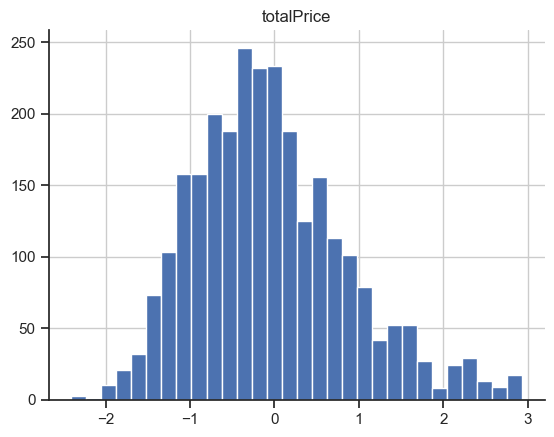

In [19]:
y_train.hist(bins=30)
plt.show()

In [20]:
feature_missing_imputer = CategoricalImputer(
    imputation_method="missing",
    fill_value="Missing",
    variables=MISSING_IMPUTER_FEATURES,
)
feature_missing_imputer.fit(X_train)

X_train = feature_missing_imputer.transform(X_train)
X_test = feature_missing_imputer.transform(X_test)

In [21]:
feature_mode_imputer = CategoricalImputer(
    imputation_method="frequent",
    variables=MODE_IMPUTER_FEATURES,
)
feature_mode_imputer.fit(X_train)

X_train = feature_mode_imputer.transform(X_train)
X_test = feature_mode_imputer.transform(X_test)

In [22]:
feature_rare_label_encoder = RareLabelEncoder(
    n_categories=1,
    tol=0.01,
    variables=CATEGORICAL_FEATURES,
)
feature_rare_label_encoder.fit(X_train)

X_train = feature_rare_label_encoder.transform(X_train)
X_test = feature_rare_label_encoder.transform(X_test)

In [23]:
feature_ordinal_encoder = OrdinalEncoder(encoding_method="ordered", variables=ORDINAL_ENCODER_FEATURES)
feature_ordinal_encoder.fit(X_train, y_train.squeeze())

X_train = feature_ordinal_encoder.transform(X_train)
X_test = feature_ordinal_encoder.transform(X_test)

In [24]:
X_train

,floor,propertyType,size,rooms,bathrooms,municipality,district,latitude,longitude,showAddress,hasVideo,status,newDevelopment,hasLift,hasPlan,has3DTour,has360,hasStaging,topNewDevelopment,topPlus,newDevelopmentFinished,isPriceLowered,hasParkingSpace,isParkingSpaceIncludedInPrice,distanceToCityCenter,distanceToNearestMall,nearestMallName,distanceToNearestTrain,nearestTrainName,distanceToNearestFair,nearestFairName,distanceToNearestPark,nearestParkName,distanceToNearestMarket,nearestMarketName,distanceToNearestMetro,nearestMetroName,distanceToNearestViewpoint,nearestViewpointName,distanceToNearestPlayground,nearestPlaygroundName,distanceToNearestBus,nearestBusName,distanceToNearestTram,nearestTramName,proximityToTransportScore,proximityToGreenSpaceScore,relativePricePerArea,listingsDensityScore
propertyCode,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
33927611,1,flat,75.0,2,1,9,0,38.745753,-9.181090,False,True,good,False,False,True,False,False,False,False,False,False,False,False,False,7495.052831,818.702643,15,1770.408717,7,2189.616837,3,233.394504,20,1410.474856,1,609.050851,9,1292.553647,7,66.730337,9,73.780263,1,3420.166048,5,0.869369,0.863055,0.923650,0.142395
33818215,1,flat,74.0,1,1,9,12,38.752713,-9.183459,False,False,good,False,True,False,False,False,False,False,False,False,False,True,True,8418.346385,659.820518,12,2153.578281,1,1171.722994,3,740.641704,20,676.242845,1,546.619363,9,2316.599158,7,528.858356,9,242.547439,1,4375.470809,5,0.567102,0.563091,0.974497,0.113269
33921433,2,flat,11.0,1,1,12,12,38.743373,-9.137448,False,False,good,False,False,False,False,False,False,False,False,False,False,False,False,5180.268320,174.002777,15,505.810977,4,322.511279,8,31.301038,20,501.572125,6,463.723883,11,1932.990573,8,116.499187,9,182.650279,1,2830.544002,6,0.674380,0.982564,5.435035,0.067961
34009508,2,flat,50.0,1,1,19,17,38.714855,-9.151628,True,False,good,False,False,True,False,False,False,False,False,False,False,False,False,2108.831662,464.767158,23,1076.115068,12,359.475106,13,29.149172,24,1331.197477,11,829.685090,20,820.700980,17,42.222276,17,5.001742,1,393.788365,10,0.992554,0.983836,0.680802,0.252427
27801065,2,flat,96.0,4,2,18,12,38.716699,-9.131327,False,False,good,False,False,False,False,False,False,False,False,False,False,False,False,1446.041414,458.594287,10,1091.344877,3,205.762881,6,48.000572,20,2142.156872,11,511.465305,19,48.197338,10,196.728478,9,122.272419,1,189.384462,8,0.782518,0.972688,0.759963,0.051780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33857958,3,flat,95.0,1,2,11,20,38.720790,-9.125598,False,True,good,False,False,False,False,False,False,False,False,False,False,True,True,2242.624988,1261.116902,10,933.439449,3,658.735265,6,709.864494,7,2185.406814,7,1044.713011,1,836.387961,5,315.247506,9,120.627570,1,486.941606,3,0.785464,0.581292,0.552764,0.275081
33873796,3,flat,168.0,3,1,13,19,38.725788,-9.132446,False,False,good,False,True,False,False,False,False,False,False,False,False,False,False,2687.758123,646.138518,7,1906.858317,12,900.989303,2,142.601804,9,1323.379656,7,326.969674,7,114.173730,3,58.249263,7,78.981431,1,276.504086,4,0.860054,0.933557,0.223001,0.233010
33888919,2,flat,150.0,4,2,18,3,38.709598,-9.130971,True,False,good,False,False,False,False,False,False,False,False,False,False,False,False,617.364630,954.331701,28,1278.135740,3,402.303647,0,302.190365,3,1692.534913,11,503.378276,25,300.053679,6,243.945829,9,131.839431,1,130.110742,8,0.768479,0.823635,0.372548,0.213592


In [25]:
feature_one_hot_encoder = OneHotEncoder(drop_last=True, variables=ONE_HOT_ENCODER_FEATURES)
feature_one_hot_encoder.fit(X_train)

X_train = feature_one_hot_encoder.transform(X_train)
X_test = feature_one_hot_encoder.transform(X_test)

In [26]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2693 entries, 33927611 to 33886688
Data columns (total 52 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   floor                          2693 non-null   int64  
 1   size                           2693 non-null   float64
 2   rooms                          2693 non-null   int64  
 3   bathrooms                      2693 non-null   int64  
 4   municipality                   2693 non-null   int64  
 5   district                       2693 non-null   int64  
 6   latitude                       2693 non-null   float64
 7   longitude                      2693 non-null   float64
 8   showAddress                    2693 non-null   bool   
 9   hasVideo                       2693 non-null   bool   
 10  newDevelopment                 2693 non-null   bool   
 11  hasLift                        2693 non-null   bool   
 12  hasPlan                        2693 non-nu

In [27]:
feature_yeo_johnson_transformer = YeoJohnsonTransformer(variables=YEO_JOHNSON_TRANSFORMER_FEATURES)
feature_yeo_johnson_transformer.fit(X_train)

X_train = feature_yeo_johnson_transformer.transform(X_train)
X_test = feature_yeo_johnson_transformer.transform(X_test)

In [28]:
X_train

,floor,size,rooms,bathrooms,municipality,district,latitude,longitude,showAddress,hasVideo,newDevelopment,hasLift,hasPlan,has3DTour,has360,hasStaging,topNewDevelopment,topPlus,newDevelopmentFinished,isPriceLowered,hasParkingSpace,isParkingSpaceIncludedInPrice,distanceToCityCenter,distanceToNearestMall,nearestMallName,distanceToNearestTrain,nearestTrainName,distanceToNearestFair,nearestFairName,distanceToNearestPark,nearestParkName,distanceToNearestMarket,nearestMarketName,distanceToNearestMetro,nearestMetroName,distanceToNearestViewpoint,nearestViewpointName,distanceToNearestPlayground,nearestPlaygroundName,distanceToNearestBus,nearestBusName,distanceToNearestTram,nearestTramName,proximityToTransportScore,proximityToGreenSpaceScore,relativePricePerArea,listingsDensityScore,propertyType_flat,propertyType_Rare,propertyType_studio,propertyType_duplex,status_good
propertyCode,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
33927611,1,5.043617,2,1,9,0,38.745753,-9.181090,False,True,False,False,True,False,False,False,False,False,False,False,False,False,48.381933,13.570871,15,15.890676,7,33.128951,3,23.314057,20,22.356202,1,5.192998,9,11.578142,7,12.013650,9,14.213691,1,9.530135,5,0.869369,0.863055,0.923650,0.142395,1,0,0,0,1
33818215,1,5.025792,1,1,9,12,38.752713,-9.183459,False,False,False,True,False,False,False,False,False,False,False,False,True,True,50.280648,12.815201,12,16.664347,1,26.594447,3,40.470301,20,17.692178,1,5.123082,9,13.056483,7,32.580886,9,26.469737,1,9.866787,5,0.567102,0.563091,0.974497,0.113269,1,0,0,0,1
33921433,2,2.709521,1,1,12,12,38.743373,-9.137448,False,False,False,False,False,False,False,False,False,False,False,False,False,False,42.781176,8.780834,15,11.545355,4,16.603845,8,8.318553,20,16.044959,6,5.015794,11,12.586200,8,15.870426,9,22.888092,1,9.273666,6,0.674380,0.982564,5.435035,0.067961,1,0,0,0,1
34009508,2,4.513831,1,1,19,17,38.714855,-9.151628,True,False,False,False,True,False,False,False,False,False,False,False,False,False,31.564858,11.652413,23,14.044341,12,17.294845,13,7.998834,24,21.954843,11,5.390095,20,10.499892,17,9.482949,17,2.824563,1,6.708734,10,0.992554,0.983836,0.680802,0.252427,1,0,0,0,1
27801065,2,5.374867,4,2,18,12,38.716699,-9.131327,False,False,False,False,False,False,False,False,False,False,False,False,False,False,27.714828,11.609575,10,14.094198,3,13.984317,6,10.475173,20,25.448559,11,5.079859,19,5.016234,10,20.463676,9,18.581214,1,5.806758,8,0.782518,0.972688,0.759963,0.051780,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33857958,3,5.360684,1,2,11,20,38.720790,-9.125598,False,True,False,False,False,False,False,False,False,False,False,False,True,True,32.236560,15.180966,10,13.546847,3,21.624606,6,39.670659,7,25.605355,7,5.534387,1,10.543620,5,25.596599,9,18.449793,1,6.975438,3,0.785464,0.581292,0.552764,0.275081,1,0,0,0,1
33873796,3,6.149657,3,1,13,19,38.725788,-9.132446,False,False,False,True,False,False,False,False,False,False,False,False,False,False,34.290029,12.743458,7,16.180632,12,24.213791,2,18.298518,9,21.914326,7,4.783955,7,6.475024,3,11.207837,7,14.742710,1,6.269649,4,0.860054,0.933557,0.223001,0.233010,1,0,0,0,1
33888919,2,5.990095,4,2,18,3,38.709598,-9.130971,True,False,False,False,False,False,False,False,False,False,False,False,False,False,20.526231,14.127016,28,14.663568,3,18.037463,0,26.421632,3,23.662644,11,5.069467,25,8.320197,6,22.675285,9,19.327965,1,5.354975,8,0.768479,0.823635,0.372548,0.213592,1,0,0,0,1


In [29]:
feature_frequent_value_amputer = FrequentValueAmputer(variables=FREQUENT_VALUE_AMPUTER_FEATURES, threshold=0.04)
feature_frequent_value_amputer.fit(X_train)

X_train = feature_frequent_value_amputer.transform(X_train)
X_test = feature_frequent_value_amputer.transform(X_test)

In [30]:
feature_frequent_value_amputer.frequent_values

{'size': [2.7095214757125374, 4.513831445047694]}

In [31]:
X_train

,floor,size,rooms,bathrooms,municipality,district,latitude,longitude,showAddress,hasVideo,newDevelopment,hasLift,hasPlan,has3DTour,has360,hasStaging,topNewDevelopment,topPlus,newDevelopmentFinished,isPriceLowered,hasParkingSpace,isParkingSpaceIncludedInPrice,distanceToCityCenter,distanceToNearestMall,nearestMallName,distanceToNearestTrain,nearestTrainName,distanceToNearestFair,nearestFairName,distanceToNearestPark,nearestParkName,distanceToNearestMarket,nearestMarketName,distanceToNearestMetro,nearestMetroName,distanceToNearestViewpoint,nearestViewpointName,distanceToNearestPlayground,nearestPlaygroundName,distanceToNearestBus,nearestBusName,distanceToNearestTram,nearestTramName,proximityToTransportScore,proximityToGreenSpaceScore,relativePricePerArea,listingsDensityScore,propertyType_flat,propertyType_Rare,propertyType_studio,propertyType_duplex,status_good
propertyCode,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
33927611,1,5.043617,2,1,9,0,38.745753,-9.181090,False,True,False,False,True,False,False,False,False,False,False,False,False,False,48.381933,13.570871,15,15.890676,7,33.128951,3,23.314057,20,22.356202,1,5.192998,9,11.578142,7,12.013650,9,14.213691,1,9.530135,5,0.869369,0.863055,0.923650,0.142395,1,0,0,0,1
33818215,1,5.025792,1,1,9,12,38.752713,-9.183459,False,False,False,True,False,False,False,False,False,False,False,False,True,True,50.280648,12.815201,12,16.664347,1,26.594447,3,40.470301,20,17.692178,1,5.123082,9,13.056483,7,32.580886,9,26.469737,1,9.866787,5,0.567102,0.563091,0.974497,0.113269,1,0,0,0,1
33921433,2,NaN,1,1,12,12,38.743373,-9.137448,False,False,False,False,False,False,False,False,False,False,False,False,False,False,42.781176,8.780834,15,11.545355,4,16.603845,8,8.318553,20,16.044959,6,5.015794,11,12.586200,8,15.870426,9,22.888092,1,9.273666,6,0.674380,0.982564,5.435035,0.067961,1,0,0,0,1
34009508,2,NaN,1,1,19,17,38.714855,-9.151628,True,False,False,False,True,False,False,False,False,False,False,False,False,False,31.564858,11.652413,23,14.044341,12,17.294845,13,7.998834,24,21.954843,11,5.390095,20,10.499892,17,9.482949,17,2.824563,1,6.708734,10,0.992554,0.983836,0.680802,0.252427,1,0,0,0,1
27801065,2,5.374867,4,2,18,12,38.716699,-9.131327,False,False,False,False,False,False,False,False,False,False,False,False,False,False,27.714828,11.609575,10,14.094198,3,13.984317,6,10.475173,20,25.448559,11,5.079859,19,5.016234,10,20.463676,9,18.581214,1,5.806758,8,0.782518,0.972688,0.759963,0.051780,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33857958,3,5.360684,1,2,11,20,38.720790,-9.125598,False,True,False,False,False,False,False,False,False,False,False,False,True,True,32.236560,15.180966,10,13.546847,3,21.624606,6,39.670659,7,25.605355,7,5.534387,1,10.543620,5,25.596599,9,18.449793,1,6.975438,3,0.785464,0.581292,0.552764,0.275081,1,0,0,0,1
33873796,3,6.149657,3,1,13,19,38.725788,-9.132446,False,False,False,True,False,False,False,False,False,False,False,False,False,False,34.290029,12.743458,7,16.180632,12,24.213791,2,18.298518,9,21.914326,7,4.783955,7,6.475024,3,11.207837,7,14.742710,1,6.269649,4,0.860054,0.933557,0.223001,0.233010,1,0,0,0,1
33888919,2,5.990095,4,2,18,3,38.709598,-9.130971,True,False,False,False,False,False,False,False,False,False,False,False,False,False,20.526231,14.127016,28,14.663568,3,18.037463,0,26.421632,3,23.662644,11,5.069467,25,8.320197,6,22.675285,9,19.327965,1,5.354975,8,0.768479,0.823635,0.372548,0.213592,1,0,0,0,1


In [32]:
# Apply AddMissingIndicator
feature_missing_indicator = AddMissingIndicator()
feature_missing_indicator.fit(X_train)

X_train = feature_missing_indicator.transform(X_train)
X_test = feature_missing_indicator.transform(X_test)

In [33]:
# Apply KNNImputer
feature_knn_imputer = SklearnTransformerWrapper(
    transformer=KNNImputer(n_neighbors=5, weights="distance"),
    variables=KNN_IMPUTER_FEATURES,
)
feature_knn_imputer.fit(X_train)

X_train = feature_knn_imputer.transform(X_train)
X_test = feature_knn_imputer.transform(X_test)

In [34]:
feature_gaussian_outlier_trimmer = OutlierTrimmer(
    capping_method="gaussian",
    tail="both",
    fold=3,
    variables=GAUSSIAN_OUTLIER_REMOVER_FEATURES,
)
feature_gaussian_outlier_trimmer.fit(X_train)

X_train, y_train = feature_gaussian_outlier_trimmer.transform_x_y(X_train, y_train)
X_test, y_test = feature_gaussian_outlier_trimmer.transform_x_y(X_test, y_test)

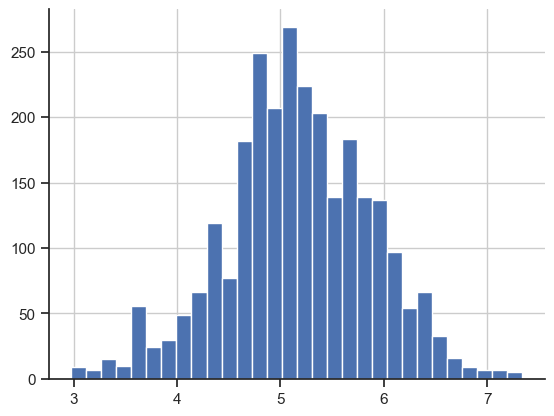

In [35]:
X_train["size"].hist(bins=30)
plt.show()

In [36]:
feature_iqr_outlier_trimmer = OutlierTrimmer(
    capping_method="iqr",
    tail="both",
    fold=1.5,
    variables=IQR_OUTLIER_REMOVER_FEATURES,
)
feature_iqr_outlier_trimmer.fit(X_train)

X_train, y_train = feature_iqr_outlier_trimmer.transform_x_y(X_train, y_train)
X_test, y_test = feature_iqr_outlier_trimmer.transform_x_y(X_test, y_test)

In [37]:
feature_rare_value_trimmer = RareValueTrimmer(
    threshold=0.01,
    variables=RARE_VALUE_OUTLIER_REMOVER_FEATURES,
)
feature_rare_value_trimmer.fit(X_train)

X_train, y_train = feature_rare_value_trimmer.transform_x_y(X_train, y_train)
X_test, y_test = feature_rare_value_trimmer.transform_x_y(X_test, y_test)

In [38]:
X_train

,floor,size,rooms,bathrooms,municipality,district,latitude,longitude,showAddress,hasVideo,newDevelopment,hasLift,hasPlan,has3DTour,has360,hasStaging,topNewDevelopment,topPlus,newDevelopmentFinished,isPriceLowered,hasParkingSpace,isParkingSpaceIncludedInPrice,distanceToCityCenter,distanceToNearestMall,nearestMallName,distanceToNearestTrain,nearestTrainName,distanceToNearestFair,nearestFairName,distanceToNearestPark,nearestParkName,distanceToNearestMarket,nearestMarketName,distanceToNearestMetro,nearestMetroName,distanceToNearestViewpoint,nearestViewpointName,distanceToNearestPlayground,nearestPlaygroundName,distanceToNearestBus,nearestBusName,distanceToNearestTram,nearestTramName,proximityToTransportScore,proximityToGreenSpaceScore,relativePricePerArea,listingsDensityScore,propertyType_flat,propertyType_Rare,propertyType_studio,propertyType_duplex,status_good,size_na,relativePricePerArea_na,listingsDensityScore_na
propertyCode,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
33927611,1,5.043617,2.0,1.0,9.0,0.0,38.745753,-9.181090,False,True,False,False,True,False,False,False,False,False,False,False,False,False,48.381933,13.570871,15,15.890676,7,33.128951,3,23.314057,20,22.356202,1,5.192998,9,11.578142,7,12.013650,9,14.213691,1,9.530135,5,0.869369,0.863055,0.923650,0.142395,1,0,0,0,1,0,0,0
33818215,1,5.025792,1.0,1.0,9.0,12.0,38.752713,-9.183459,False,False,False,True,False,False,False,False,False,False,False,False,True,True,50.280648,12.815201,12,16.664347,1,26.594447,3,40.470301,20,17.692178,1,5.123082,9,13.056483,7,32.580886,9,26.469737,1,9.866787,5,0.567102,0.563091,0.974497,0.113269,1,0,0,0,1,0,0,0
33921433,2,3.872051,1.0,1.0,12.0,12.0,38.743373,-9.137448,False,False,False,False,False,False,False,False,False,False,False,False,False,False,42.781176,8.780834,15,11.545355,4,16.603845,8,8.318553,20,16.044959,6,5.015794,11,12.586200,8,15.870426,9,22.888092,1,9.273666,6,0.674380,0.982564,5.435035,0.067961,1,0,0,0,1,1,0,0
34009508,2,5.154248,1.0,1.0,19.0,17.0,38.714855,-9.151628,True,False,False,False,True,False,False,False,False,False,False,False,False,False,31.564858,11.652413,23,14.044341,12,17.294845,13,7.998834,24,21.954843,11,5.390095,20,10.499892,17,9.482949,17,2.824563,1,6.708734,10,0.992554,0.983836,0.680802,0.252427,1,0,0,0,1,1,0,0
27801065,2,5.374867,4.0,2.0,18.0,12.0,38.716699,-9.131327,False,False,False,False,False,False,False,False,False,False,False,False,False,False,27.714828,11.609575,10,14.094198,3,13.984317,6,10.475173,20,25.448559,11,5.079859,19,5.016234,10,20.463676,9,18.581214,1,5.806758,8,0.782518,0.972688,0.759963,0.051780,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33857958,3,5.360684,1.0,2.0,11.0,20.0,38.720790,-9.125598,False,True,False,False,False,False,False,False,False,False,False,False,True,True,32.236560,15.180966,10,13.546847,3,21.624606,6,39.670659,7,25.605355,7,5.534387,1,10.543620,5,25.596599,9,18.449793,1,6.975438,3,0.785464,0.581292,0.552764,0.275081,1,0,0,0,1,0,0,0
33873796,3,6.149657,3.0,1.0,13.0,19.0,38.725788,-9.132446,False,False,False,True,False,False,False,False,False,False,False,False,False,False,34.290029,12.743458,7,16.180632,12,24.213791,2,18.298518,9,21.914326,7,4.783955,7,6.475024,3,11.207837,7,14.742710,1,6.269649,4,0.860054,0.933557,0.223001,0.233010,1,0,0,0,1,0,0,0
33888919,2,5.990095,4.0,2.0,18.0,3.0,38.709598,-9.130971,True,False,False,False,False,False,False,False,False,False,False,False,False,False,20.526231,14.127016,28,14.663568,3,18.037463,0,26.421632,3,23.662644,11,5.069467,25,8.320197,6,22.675285,9,19.327965,1,5.354975,8,0.768479,0.823635,0.372548,0.213592,1,0,0,0,1,0,0,0


In [39]:
boolean_vars = X_train.select_dtypes(include="bool").columns.tolist()
binary_vars = [
    var for var in X_train.columns if X_train[var].nunique() == 2 or var in boolean_vars
]
non_binary_vars = [var for var in X_train.columns if var not in binary_vars]

In [40]:
feature_standard_scaler = SklearnTransformerWrapper(
    transformer=StandardScaler(),
    variables=STANDARD_SCALER_FEATURES,
)
feature_standard_scaler.fit(X_train)

X_train = feature_standard_scaler.transform(X_train)
X_test = feature_standard_scaler.transform(X_test)

In [41]:
unary_feature_dropper = UnaryFeatureDropper()
unary_feature_dropper.fit(X_train)

X_train, y_train = unary_feature_dropper.transform_x_y(X_train, y_train)
X_test, y_test = unary_feature_dropper.transform_x_y(X_test, y_test)

In [48]:
y_train.loc[X_train["relativePricePerArea"].isnull().index]

,totalPrice
propertyCode,
33927611,-0.574784
33818215,-0.561307
33921433,-0.406249
34009508,-0.928641
27801065,0.427180
...,...
33857958,0.299889
33873796,-0.629610
33888919,0.018303


In [42]:
sel_ = SelectFromModel(Lasso(alpha=0.001, random_state=42))

# train Lasso model and select features
sel_.fit(X_train, y_train)

ValueError: Input X contains NaN.
Lasso does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
# this is how we can make a list of the selected features
selected_feats = X_train.columns[(sel_.get_support())]
dropped_feats = X_train.columns[(~sel_.get_support())] 

# let's print some stats
print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feats)))
print('features with coefficients shrank to zero: {}'.format(
    np.sum(sel_.estimator_.coef_ == 0)))

total features: 46
selected features: 21
features with coefficients shrank to zero: 25


In [ ]:
selected_feats

Index(['size', 'rooms', 'bathrooms', 'district', 'latitude', 'showAddress',
       'hasVideo', 'hasLift', 'hasParkingSpace', 'distanceToCityCenter',
       'distanceToNearestTrain', 'distanceToNearestFair', 'nearestFairName',
       'distanceToNearestPark', 'nearestParkName', 'distanceToNearestMarket',
       'nearestMetroName', 'nearestViewpointName', 'nearestBusName',
       'nearestTramName', 'size_na'],
      dtype='object')

In [ ]:
dropped_feats

Index(['floor', 'municipality', 'longitude', 'newDevelopment', 'hasPlan',
       'has3DTour', 'has360', 'hasStaging', 'newDevelopmentFinished',
       'isParkingSpaceIncludedInPrice', 'distanceToNearestMall',
       'nearestMallName', 'nearestTrainName', 'nearestMarketName',
       'distanceToNearestMetro', 'distanceToNearestViewpoint',
       'distanceToNearestPlayground', 'nearestPlaygroundName',
       'distanceToNearestBus', 'distanceToNearestTram', 'propertyType_flat',
       'propertyType_Rare', 'propertyType_studio', 'propertyType_duplex',
       'status_good'],
      dtype='object')

In [ ]:
X_train = X_train[selected_feats]
X_test = X_test[selected_feats]

In [ ]:
def plot_residuals(model, X_train, y_train, X_test, y_test, target_transformer=None):
    """
    Fits the model on the training data, predicts on both training and test sets,
    optionally applies an inverse transformation to the target values, calculates residuals,
    and plots the residuals for both datasets.

    Parameters:
    - model: A regression model with fit() and predict() methods.
    - X_train: Training features.
    - y_train: Training target values.
    - X_test: Test features.
    - y_test: Test target values.
    - target_transformer: (Optional) A transformer (e.g., from sklearn.preprocessing) with an inverse_transform() method.
                          Defaults to None.
    """

    # Generate predictions as pandas DataFrame
    y_train_pred = pd.DataFrame(
        data=model.predict(X_train).squeeze(),
        columns=TARGET,
        index=X_train.index,
    )
    y_test_pred = pd.DataFrame(
        data=model.predict(X_test).squeeze(),
        columns=TARGET,
        index=X_test.index,
    )

    # If a target_transformer is provided, inverse transform both actual and predicted targets.
    if target_transformer is not None:
        y_train = target_transformer.inverse_transform(pd.DataFrame(y_train))
        y_test = target_transformer.inverse_transform(pd.DataFrame(y_test))
        y_train_pred = target_transformer.inverse_transform(y_train_pred)
        y_test_pred = target_transformer.inverse_transform(y_test_pred)

    # Calculate residuals: actual - predicted
    train_residuals = y_train - y_train_pred
    test_residuals = y_test - y_test_pred

    # Create subplots for training and test residuals
    _, ax = plt.subplots(1, 2, figsize=(14, 6))

    # Plot training residuals
    ax[0].scatter(y_train_pred, train_residuals, alpha=0.1, color="blue")
    ax[0].axhline(0, color="red", linestyle="--")
    ax[0].set_title("Training Residuals")
    ax[0].set_xlabel("Predicted Values")
    ax[0].set_ylabel("Residuals")

    # Plot test residuals
    ax[1].scatter(y_test_pred, test_residuals, alpha=0.1, color="green")
    ax[1].axhline(0, color="red", linestyle="--")
    ax[1].set_title("Test Residuals")
    ax[1].set_xlabel("Predicted Values")
    ax[1].set_ylabel("Residuals")

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_true_vs_pred(model, X_train, y_train, X_test, y_test, target_transformer=None):
    """
    Fits the model on the training data, predicts on both training and test sets,
    optionally applies an inverse transformation to the target values, plots the
    true vs. predicted target values for both datasets, and displays the R2 and MAE metrics.

    Parameters:
    - model: A regression model with fit() and predict() methods.
    - X_train: Training features.
    - y_train: Training target values.
    - X_test: Test features.
    - y_test: Test target values.
    - target_transformer: (Optional) A transformer (e.g., from sklearn.preprocessing)
      with an inverse_transform() method. Defaults to None.
    """

    # Generate predictions as pandas DataFrame
    y_train_pred = pd.DataFrame(
        data=model.predict(X_train).squeeze(),
        columns=TARGET,
        index=X_train.index,
    )
    y_test_pred = pd.DataFrame(
        data=model.predict(X_test).squeeze(),
        columns=TARGET,
        index=X_test.index,
    )

    # If a target_transformer is provided, inverse transform both actual and predicted targets.
    if target_transformer is not None:
        y_train = target_transformer.inverse_transform(pd.DataFrame(y_train))
        y_test = target_transformer.inverse_transform(pd.DataFrame(y_test))
        y_train_pred = target_transformer.inverse_transform(y_train_pred)
        y_test_pred = target_transformer.inverse_transform(y_test_pred)

    # Convert targets and predictions to numpy arrays and flatten for metric calculations.
    y_train_true = np.asarray(y_train).flatten()
    y_train_pred_val = np.asarray(y_train_pred).flatten()
    y_test_true = np.asarray(y_test).flatten()
    y_test_pred_val = np.asarray(y_test_pred).flatten()

    # Compute metrics
    r2_train = r2_score(y_train_true, y_train_pred_val)
    mae_train = mean_absolute_error(y_train_true, y_train_pred_val)
    r2_test = r2_score(y_test_true, y_test_pred_val)
    mae_test = mean_absolute_error(y_test_true, y_test_pred_val)

    # Use np.min and np.max to extract scalar min and max values for the ideal line.
    train_min = min(np.min(y_train_true), np.min(y_train_pred_val))
    train_max = max(np.max(y_train_true), np.max(y_train_pred_val))
    test_min = min(np.min(y_test_true), np.min(y_test_pred_val))
    test_max = max(np.max(y_test_true), np.max(y_test_pred_val))

    # Create subplots for training and test true vs. predicted plots
    _, ax = plt.subplots(1, 2, figsize=(14, 6))

    # Plot true vs. predicted for training data
    ax[0].scatter(y_train_true, y_train_pred_val, alpha=0.1, color="blue")
    ax[0].plot([train_min, train_max], [train_min, train_max], color="red", linestyle="--")
    ax[0].set_title("Training: True vs. Predicted")
    ax[0].set_xlabel("True Values")
    ax[0].set_ylabel("Predicted Values")
    # Display training metrics on the plot
    ax[0].text(0.05, 0.95, f"R² = {r2_train:.3f}\nMAE = {mae_train:.3f}", 
               transform=ax[0].transAxes, verticalalignment='top',
               bbox=dict(facecolor='white', alpha=0.1))

    # Plot true vs. predicted for test data
    ax[1].scatter(y_test_true, y_test_pred_val, alpha=0.1, color="green")
    ax[1].plot([test_min, test_max], [test_min, test_max], color="red", linestyle="--")
    ax[1].set_title("Test: True vs. Predicted")
    ax[1].set_xlabel("True Values")
    ax[1].set_ylabel("Predicted Values")
    # Display test metrics on the plot
    ax[1].text(0.05, 0.95, f"R² = {r2_test:.3f}\nMAE = {mae_test:.3f}", 
               transform=ax[1].transAxes, verticalalignment='top',
               bbox=dict(facecolor='white', alpha=0.1))

    plt.tight_layout()
    plt.show()

In [ ]:
X_train_dev, X_val, y_train_dev, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    random_state=42,
    shuffle=True,
)

In [ ]:
linear_model = LinearRegression()
linear_model.fit(X_train_dev, y_train_dev)

LinearRegression()

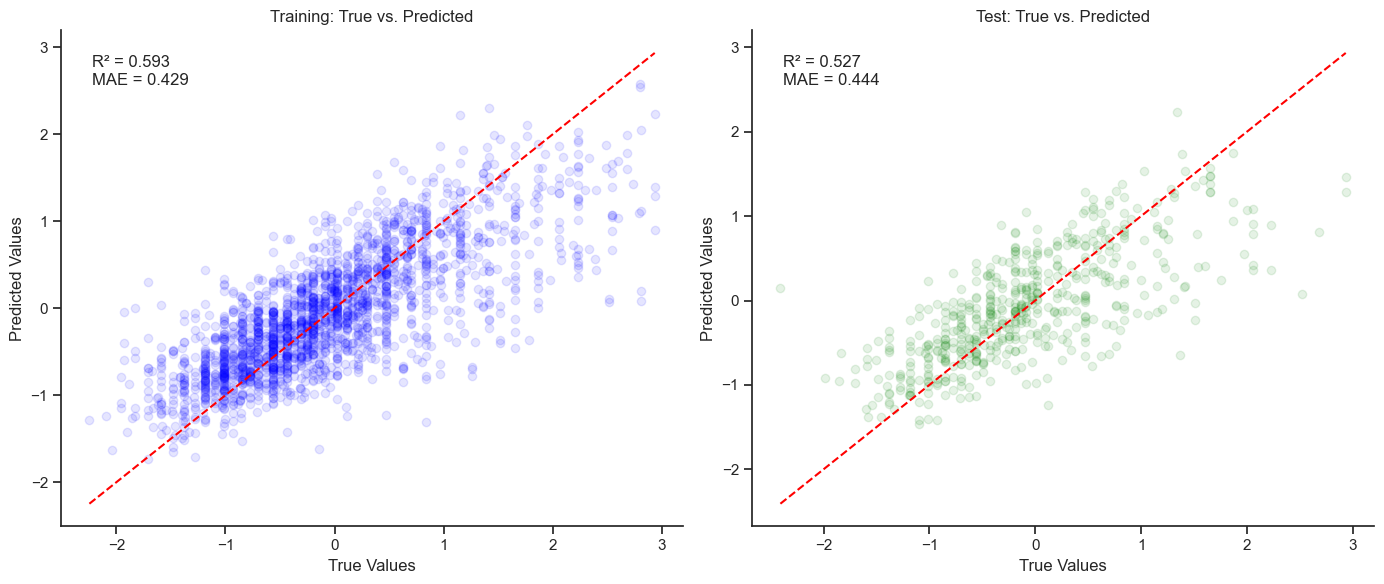

In [ ]:
plot_true_vs_pred(linear_model, X_train_dev, y_train_dev, X_val, y_val, target_transformer=None,)

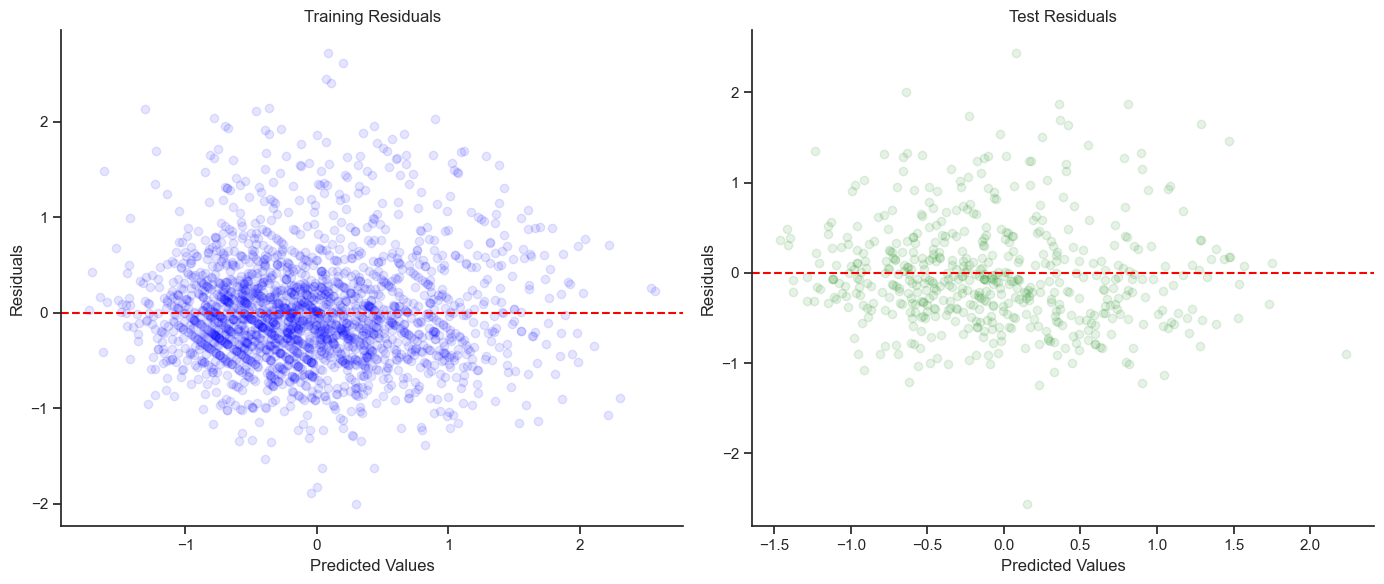

In [ ]:
plot_residuals(linear_model, X_train_dev, y_train_dev, X_val, y_val, target_transformer=None,)

In [ ]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

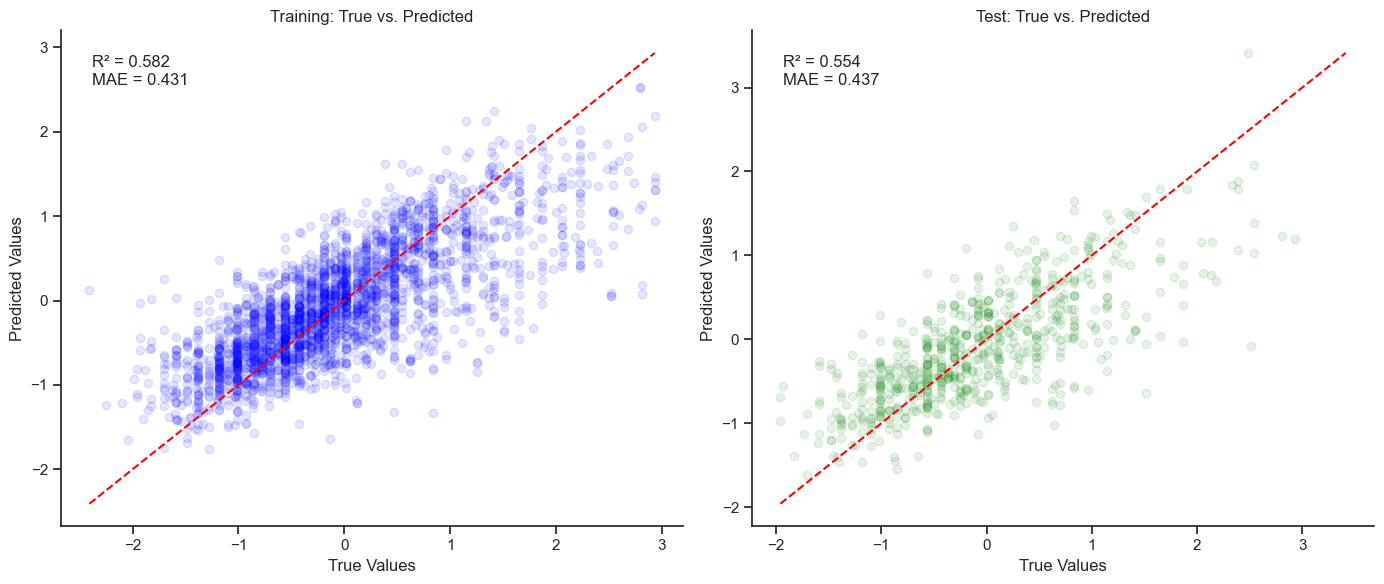

In [ ]:
plot_true_vs_pred(linear_model, X_train, y_train, X_test, y_test, target_transformer=None,)

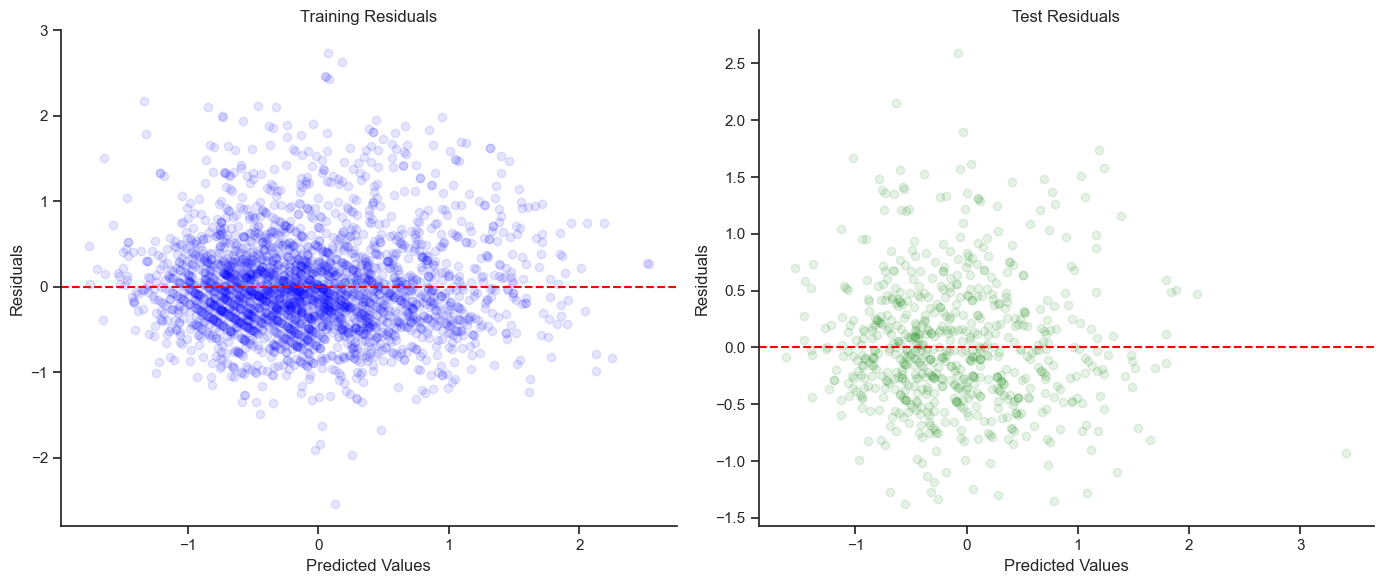

In [ ]:
plot_residuals(linear_model, X_train, y_train, X_test, y_test, target_transformer=None,)

In [ ]:
elastic_net_model = ElasticNet(alpha=0.01, l1_ratio=0.5, random_state=42)
elastic_net_model.fit(X_train_dev, y_train_dev)

y_pred_dev = elastic_net_model.predict(X_train_dev)
y_pred_val = elastic_net_model.predict(X_val)

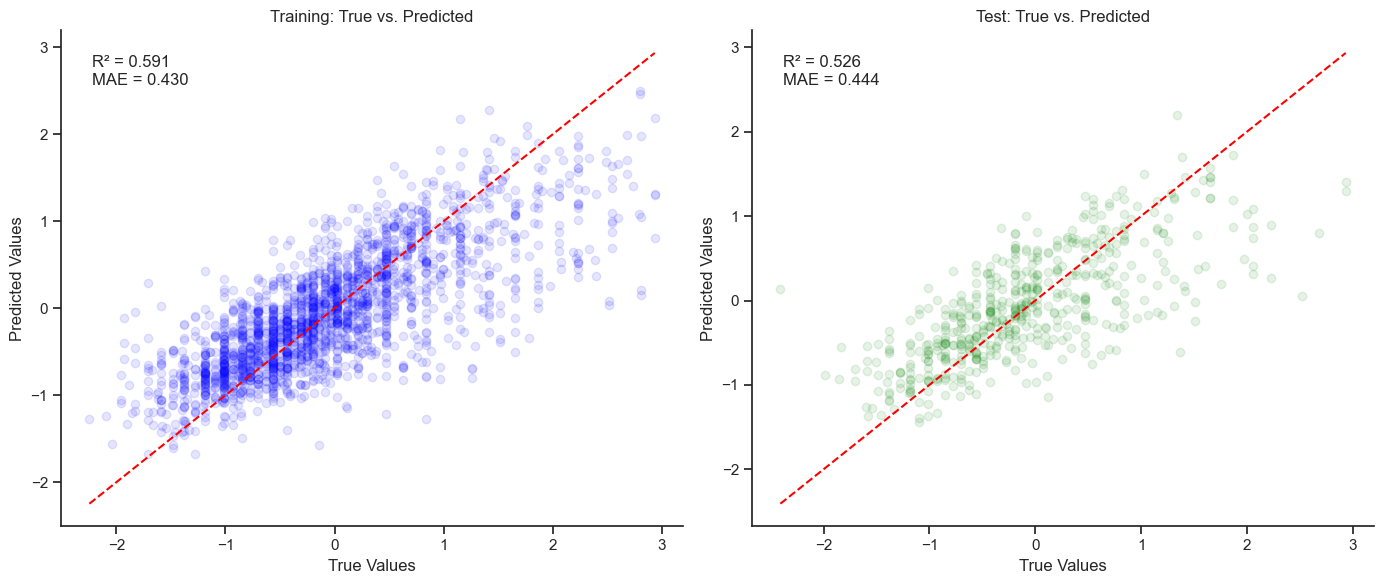

In [ ]:
plot_true_vs_pred(elastic_net_model, X_train_dev, y_train_dev, X_val, y_val, target_transformer=None,)

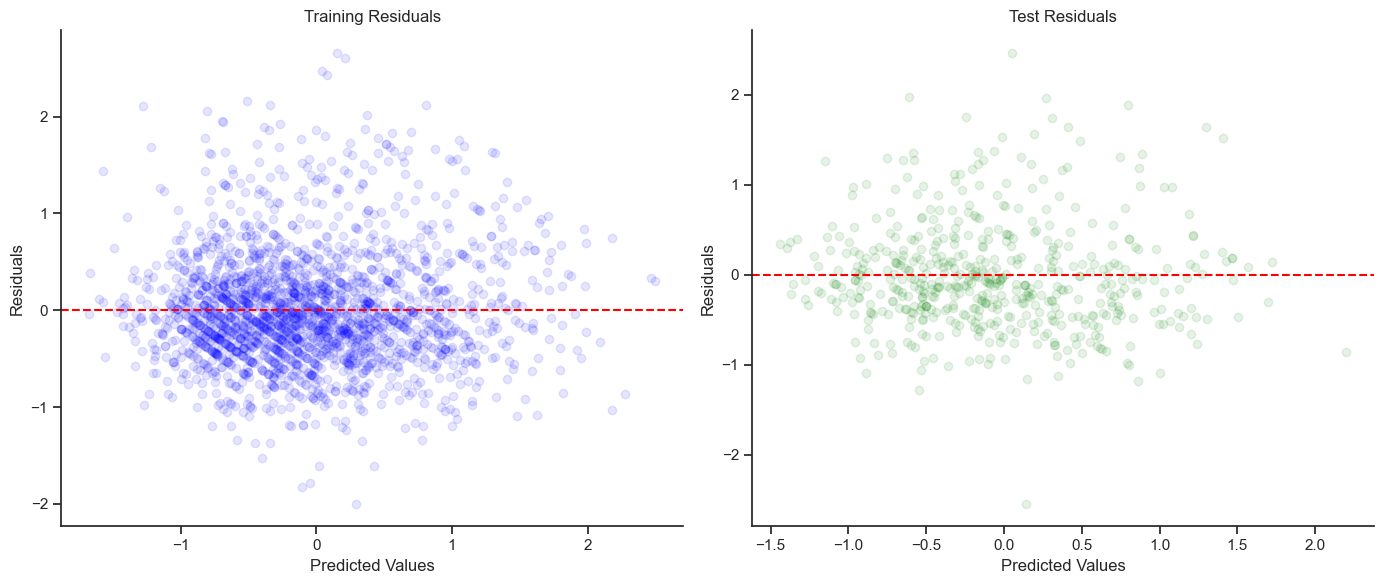

In [ ]:
plot_residuals(elastic_net_model, X_train_dev, y_train_dev, X_val, y_val, target_transformer=None,)

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the Elastic Net model
model = ElasticNet(max_iter=10000)

# Parameter grid to search
param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10],   # Regularization strength
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9, 1.0],   # L1/L2 mixing
    'max_iter': [1000, 5000, 10000],              # Ensures convergence
    'tol': [1e-4, 1e-3, 1e-2]                     # Convergence tolerance
}

# Grid search with cross-validation
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Best alpha: {grid_search.best_params_['alpha']}")
print(f"Best l1_ratio: {grid_search.best_params_['l1_ratio']}")
print(f"Best RMSE: {np.sqrt(-grid_search.best_score_)}")

Best alpha: 0.01
Best l1_ratio: 0.1
Best RMSE: 0.5834668147850784


In [ ]:
improved_elastic_net_model = ElasticNet(**grid_search.best_params_, random_state=42)
improved_elastic_net_model.fit(X_train, y_train)

ElasticNet(alpha=0.01, l1_ratio=0.1, random_state=42, tol=0.01)

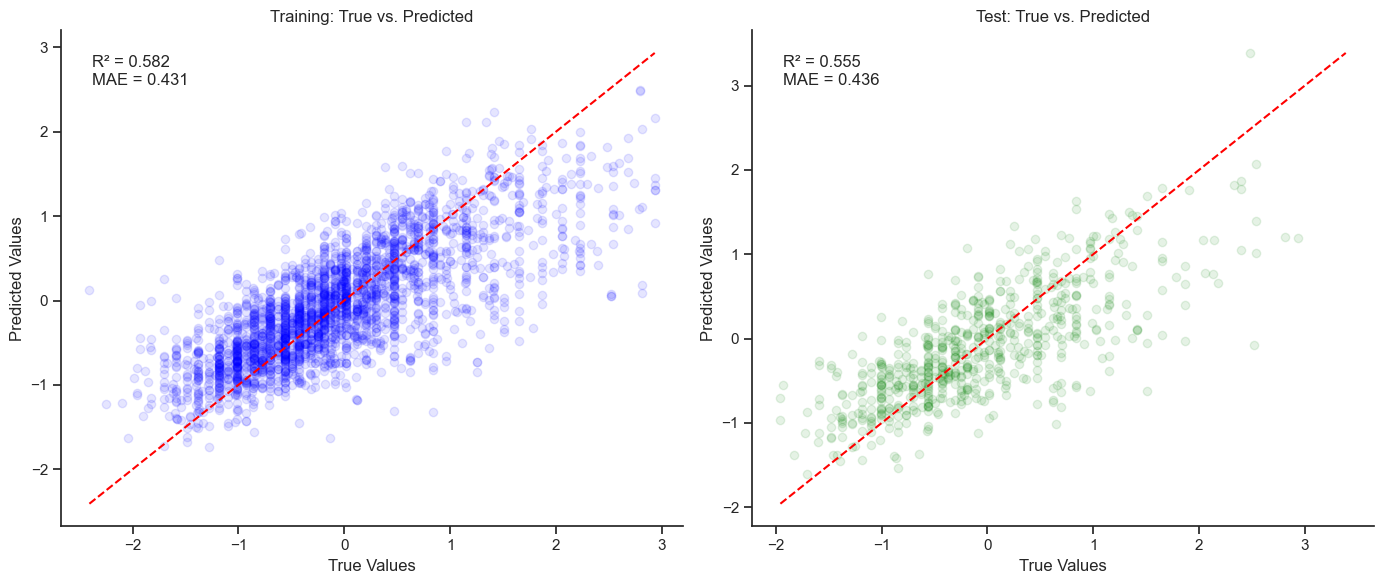

In [ ]:
plot_true_vs_pred(improved_elastic_net_model, X_train, y_train, X_test, y_test, target_transformer=None,)

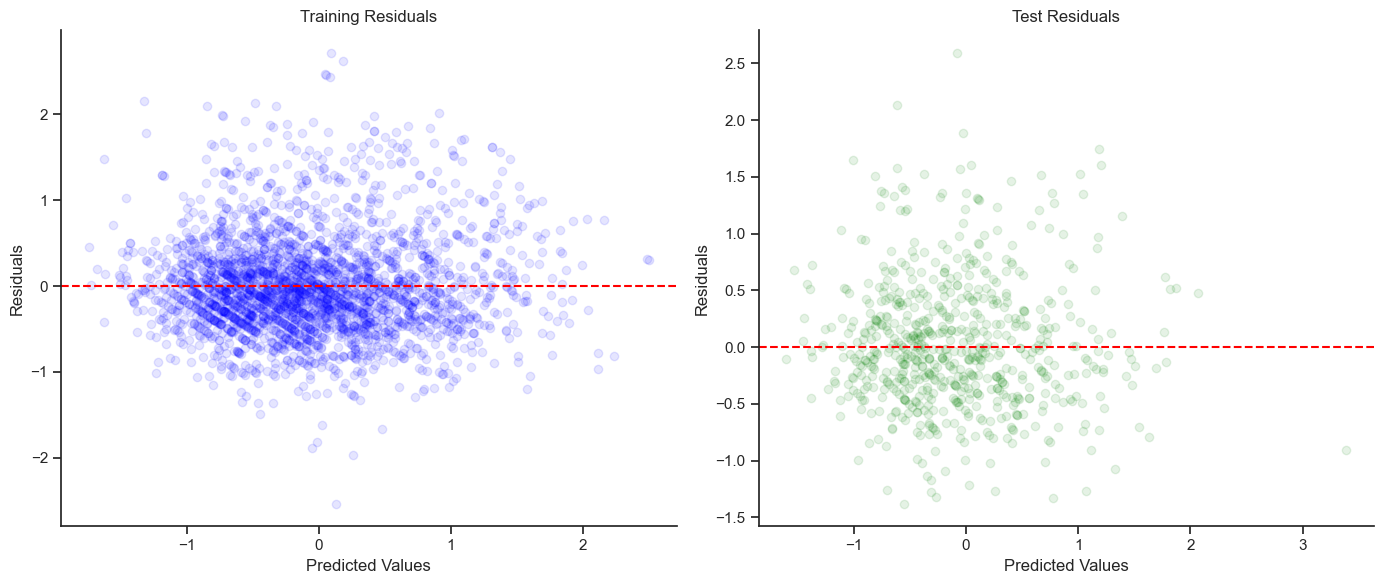

In [ ]:
plot_residuals(improved_elastic_net_model, X_train, y_train, X_test, y_test, target_transformer=None,)